In [1]:
from header import *
plt.rcParams.update({'font.size': 14})

In [2]:
df_seeds = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
df_base = read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv')

#df_seeds = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df_base = read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv')

display(df_seeds.head())

,ref,refsize,algo,operation,memory,len,read,spell,cost,starts,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states
readname,,,,,,,,,,,,,,,,,,
all-393,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TTACAGCATTACGCCAGACCTATGAAGAGGTCCTGCGACTGGCGGT...,TTAcAGCATTACGCCAGaCCTATGAAGAGGtCCTGCGACTGGCGGT...,4,-1,0.672,0.092,0.0,0.002526,0.000151,1,0.764,168.0
all-392,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,CGACGGACAGCAATACTGAAAGCATCAGTCCTCCAGAAATAAGGCC...,CGACgGaCAGCAATACTGAAAGcATCAGTcCTCCaGAAATAAGGCC...,5,-1,1.156,0.144,0.0,0.004610,0.000320,1,1.300,289.0
all-391,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,GCGACGAGGCAATATTGGCGGCGAATGTCCGGCGCTGGCGACCACG...,GCGACGAGGCAAtATTgGCGGCGaATGTCCGGCGCTGGCGACCACG...,3,-1,0.800,0.108,0.0,0.002814,0.000181,1,0.908,200.0
all-390,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,CCTTGTCCGTATGTTCCCAATCAAGTGCTGTACCGGGATTATCGAT...,CCTTgTCCgTATGtTCCCAATCAAGTGCTGTAcCGGGATTATCGAT...,4,-1,1.124,0.136,0.0,0.003381,0.000225,1,1.260,281.0
all-389,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,ATCGGCACTGCTGATTTCACCATCCGTGCGTAAATAAAACCGGGTG...,ATCGGCAcTGcTGATTtCACCATcCGTGCGTAAATAAAACCGGGTG...,6,-1,1.324,0.144,0.0,0.004019,0.000315,1,1.468,331.0


In [3]:
def cross_validation(seeds, base):
    correct = True
    for index, row in df_seeds.iterrows():
        #display(row)
        a = df_base[df_base['read'] == row['read']]
        assert(len(a) == 1)
        r = a.iloc[0]
        if row.cost != r.cost:
            print("Mismatching costs: ", row.cost, " != ", r.cost)
            print(row)
            print(r)
            correct = False
    print('Checked ' + str(len(df_seeds)) + ' alignments.')
    return correct

In [4]:
cross_validation(df_seeds, df_base)

Checked 393 alignments.


True

In [5]:
def read_maf(fn):
    L = []
    loc = -1
    readname = 'empty'
    strand = '?'
    for line in open(fn, 'r').readlines():
        arr = line.split()
        if len(arr) == 0:
            continue
        if arr[0] == 'a':
            loc = -1
            readname = 'empty'
            continue
        if arr[1] == 'ref':
            loc  = int(arr[2])
        else:
            readname = arr[1]
            strand = arr[4]
            L.append([readname, loc, strand])
    df = pd.DataFrame(L, columns=['readname', 'gt_loc', 'gt_strand'])
    df.set_index('readname', inplace=True)
    return df

In [6]:
def compare_eq(df, col1='minimap_loc', col2='gt_loc'):
    eq, diff = 0, 0
    for index, row in df.iterrows():
        if abs(row[col1]-row[col2]) < 1000:
            eq += 1
        else:
            #print("Mistake: ", index, row[col1], row[col2])
            diff += 1
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' overlaps with ' + col2 + ' in:', eq)
    print('differs in: {} ({:.3}%)'.format(diff, 100.0*diff/(eq+diff)))

In [7]:
def str2errors(s):
    n, errors = 0, 0
    for c in s:
        if c >= '0' and c <= '9':
            n = n*10 + int(c)
        else:
            if c == 'S' or c == 'D' or c == 'I':
                errors += n
            else:
                assert(c == 'M')
            n = 0
    return errors

In [8]:
from collections import defaultdict

def plot_correctness_fast(df, corr_col, q_len_col, d):
    total = defaultdict(int)
    correct = defaultdict(int)
    
    for idx, r in df.iterrows():
        bucket = r[q_len_col] // d
        total[bucket] += 1
        if r[corr_col]:
            correct[bucket] += 1
    
    h = {}
    for bucket, t in total.items():
        l = (bucket+0.5)*d
        if l>=100 and t>5:
            h[l] = 100.0 * (1.0 - correct[bucket] / t)
            
    c = pd.DataFrame(list(h.items()), columns = ['len', '% misaligned'])
    c.sort_values(by=['len'], inplace=True)
    print(c)
    c.plot('len', '% misaligned', title=corr_col)

def plot_correctness(df, corr_col, q_len_col, d):
    h = {}
    for i in range(0,1000,d):
        h[i] = (100.0 - 100.0 * sum([ r[corr_col] for idx, r in df.iterrows() if r[q_len_col] >= i and r[q_len_col] < i+d ]) / (1+sum([ 1 for idx, r in df.iterrows() if r[q_len_col] >= i and r[q_len_col] < i+d ])))
    c = pd.DataFrame(list(h.items()), columns = ['len', '% correct alignments'], sort_columns=True)
    print(c)
    c.plot('len', '% correct alignments', title=corr_col)

def check_minimap(minimap_sam_fn, seeds_tsv_fn, gt_maf_fn):
    print(minimap_sam_fn)
    print(seeds_tsv_fn)
    print(gt_maf_fn)
    
    df_minimap = pd.read_csv(minimap_sam_fn, skiprows=2, header=None, delim_whitespace=True, index_col=0, usecols=[0,1,2,3,4,5,6,7,8,9,10])
    #df_minimap = df_minimap.set_index(0, verify_integrity=True)
#    df_minimap['minimap_nm_cost'] = [ int(x.split(':')[2]) for x in df_minimap[10] ]
#    df_minimap['minimap_str_cost'] = [ str2errors(s) for s in df_minimap[4] ]
    df_minimap['minimap_loc'] = [ int(x) if x != '*' else -100000 for x in df_minimap[2] ]
    df_minimap['query_len'] = [ len(s) for s in df_minimap[8] ]
    
    df_seeds = read_astarix_performance(seeds_tsv_fn)
    #display(df_seeds.tail())
    #display(df_minimap.tail())
    
    
    print(df_seeds.shape, df_minimap.shape)
    print("Difference:", set(df_seeds.index).symmetric_difference(set(df_minimap.index)) )
    #assert(set(df_seeds.index) == set(df_minimap.index))
    
    df_gt = read_maf(gt_maf_fn)
    
    df = df_minimap
    df = df.join(df_seeds, sort=True)
    df = df.join(df_gt, sort=True)
    
    df.drop(df[df.gt_strand == '-'].index, inplace=True)
    display(df.head())
    
    df['is_correct_minimap'] = [ abs(r['minimap_loc'] - r['gt_loc']) < 1000 for idx, r in df.iterrows() ]
    df['is_correct_seeds'] = [ abs(r['start'] - r['gt_loc']) < 1000 for idx, r in df.iterrows() ]
    
    display(df[df.is_correct_seeds == 0].head())
    
    compare_eq(df, 'minimap_loc', 'gt_loc')
    compare_eq(df, 'start', 'gt_loc')
    ax = df['query_len'].plot.hist(bins=30, alpha=0.5)
    
    plot_correctness_fast(df, 'is_correct_minimap', 'query_len', d=30)
    plot_correctness_fast(df, 'is_correct_seeds', 'query_len', d=30)
    
    #plt.savefig('plots'/(prefix+'_'+x+'-'+y+'.png'), bbox_inches='tight')
    #draw_plot(df, 'query_len', 'is_correct')

results/ecoli_head1000000_linear_long_ccs/minimap2/aln.sam
results/ecoli_head1000000_linear_long_ccs/astar-seeds/alignments.tsv
results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf
(109202, 19) (109171, 12)
Difference: {'S1_13860', 'S1_13855', 'S1_13852', 'S1_13850', 'S1_49771', 'S1_49777', 'S1_49779', 'S1_13841', 'S1_13848', 'S1_49773', 'S1_13851', 'S1_49770', 'S1_13844', 'S1_13854', 'S1_13840', 'S1_49778', 'S1_49776', 'S1_49772', 'S1_13858', 'S1_13859', 'S1_13843', 'S1_13847', 'S1_49774', 'S1_49775', 'S1_13857', 'S1_13846', 'S1_13853', 'S1_13849', 'S1_13842', 'S1_13856', 'S1_13845'}


,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_1,0,435946,60,43M1D4M1I59M1D7M1D60M1D19M1D66M1I2M4S,*,0,0,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,%CUNM@FeE50F;?7:D>@K@'1FM60<*+*&D\SA@A>6(D/:5;...,NM:i:9,435946,266,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435951,+,9.191729,1.887218,0.0,0.028372,0.002892,0,11.078947,2444.999914,435945,+
S1_100001,0,448006,60,149M1D140M1D8M,*,0,0,CTGCCATGGGACGCGCCGCTGTGATCGGTAGAATGACTCATTACAT...,~kei~Ie8UkCTRS`~~y3Vfo8~~yw'~~~fWG~~UM~m~Aq~E~...,NM:i:2,448006,297,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,297,CTGCCATGGGACGCGCCGCTGTGATCGGTAGAATGACTCATTACAT...,CTGCCATGGGACGCGCCGCTGTGATCGGTAGAATGACTCATTACAT...,2,448010,+,0.447811,0.060606,0.0,0.003127,0.000228,1,0.508417,132.999867,448005,+
S1_100003,0,329263,60,176M1D28M,*,0,0,TTCATTTATTGCTTCCAGTGTGGCGTCGATCAGTTGTCTGCGCCGG...,`~^dJSYUf~~nvy~z~_X~l~HoO@v;q~~~NWNFYV`nSKCxs~...,NM:i:1,329263,204,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,204,TTCATTTATTGCTTCCAGTGTGGCGTCGATCAGTTGTCTGCGCCGG...,TTCATTTATTGCTTCCAGTGTGGCGTCGATCAGTTGTCTGCGCCGG...,1,329266,+,0.558824,0.078431,0.0,0.003588,0.000174,1,0.637255,114.000096,329262,+
S1_100005,0,393365,60,131M1D78M1D69M1I4M1D11M,*,0,0,TATCGCTGATTACAAAGATAAAGAAATTATCTACGTAAACGACGTC...,"SrSYC^?-F~MJ0AH[YxK-=ZB?4PE,:ADAAK=dH.>E-086`U...",NM:i:4,393365,294,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,294,TATCGCTGATTACAAAGATAAAGAAATTATCTACGTAAACGACGTC...,TATCGCTGATTACAAAGATAAAGAAATTATCTACGTAAACGACGTC...,4,393369,+,0.500000,0.088435,0.0,0.003355,0.000230,1,0.588435,147.000000,393364,+
S1_100007,0,495801,60,16M1D32M1D46M1D43M1D90M1D20M1D32M1D13M3S,*,0,0,AACAAAGCGCAGGCGCGTGGACTCGTAACAAGTCGGAAATCACCGA...,4BM9(c~rg|{AWWSE~Y>Ln`IUYEYe4~Os=~+~LZQ~U;~~dQ...,NM:i:7,495801,295,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,295,AACAAAGCGCAGGCGCGTGGACTCGTAACAAGTCGGAAATCACCGA...,AACAAAGCGCAGGCGCGTGGACTCGTAACAAGTCGGAAATCACCGA...,8,495811,+,0.766102,0.145763,0.0,0.004840,0.000289,1,0.911865,226.000090,495800,+


,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand,is_correct_minimap,is_correct_seeds
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_10045,0,15664,0,25M1I42M1I10M1D56M1D6M1I22M1D90M1D40M2S,*,0,0,GACGTGGCTCTCCTGAAGCGGCTGCAGGAATGCCGCCGACTGGTTT...,"7'9?@?(h*;?97++M7X@5e9H7>$?N4C8ADF.4IDGN,K3;R7...",NM:i:7,15664,296,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,296,GACGTGGCTCTCCTGAAGCGGCTGCAGGAATGCCGCCGACTGGTTT...,GACGTGGCTCTCCTGAAGCGGCTGCaGGAATGCCGCCGACTGGTTT...,8,608288,+,0.722973,0.199324,0.0,0.004034,0.000291,1,0.922297,214.000008,15663,+,True,False
S1_100949,0,688677,0,35M1D127M1D30M1D40M1D2M1D5M1D70M1D4M,*,0,0,CCGGCAAGGCGCTATCCAGGGATAACCGGGCAAACGACGCATGGAG...,"Q~~J~RhRgl~\QI]y=b:~YNj}W~s~~x~P`T^HV~^kHS~]L,...",NM:i:7,688677,313,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,313,CCGGCAAGGCGCTATCCAGGGATAACCGGGCAAACGACGCATGGAG...,CCGGCAAGGCGCTATCCAGGGATAACCGGGCAAACGACGCATGGAG...,7,274790,+,5.242812,1.134185,0.0,0.024797,0.003179,1,6.376997,1641.000156,688676,+,True,False
S1_102723,16,315463,0,18M1I21M1D12M1D63M1D23M1D72M1D57M,*,0,0,CGTCTTCTGAACGTGAACTTGGAGATGTCTACCGAGATTGACGTCT...,">9-2@8JF7Q$NEBA1C<9$2)9)=J0(E:1:B=4F%,)9)-49-+...",NM:i:8,315463,267,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,267,GCAGTGTTGGCGGAACTGCTGACGCGTGCTTATCCTTGTCCGCCGC...,GCAGTGTTGGCGGAACTGCTGACGCGTGCTTATCCTTGTCCGCCGC...,8,566749,-,2.483146,0.501873,0.0,0.009696,0.000960,1,2.985019,662.999982,392458,+,False,False
S1_103797,0,279175,0,24M1D56M1D39M1D111M2D6M1D73M,*,0,0,AACTTATTGATAGTGTTTTATGTTAGATAATGCCCGATGACTTTGT...,w~r~m~~~H~0h~O~~]{u~~C~~K\VpTM<z~cYPVAHb~J~YGe...,NM:i:6,279175,309,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,309,AACTTATTGATAGTGTTTTATGTTAGATAATGCCCGATGACTTTGT...,AACTTATTGATAGTGTTTTATGTTAGATAATGCCCGATGACTTTGT...,6,290654,+,1.844660,0.330097,0.0,0.008998,0.001040,1,2.174757,569.999940,279174,+,True,False
S1_103799,0,19869,0,73M1D29M1D3M1D102M1D81M1D4M1D23M,*,0,0,GATTTTGAGAACGACAGCGACTTCCGTCCCAGCCGTGCCAGGTGCT...,aL~SSO~1LW7W@[H]=~0ZB_LFXWt9.=6PFffxEM[N6Qi0?>...,NM:i:6,19869,315,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,315,GATTTTGAGAACGACAGCGACTTCCGTCCCAGCCGTGCCAGGTGCT...,GATTTTGAGAACGACAGCGACTTCCGTCCCAGCCGTGCCAGGTGCT...,6,19877,+,2.142857,0.457143,0.0,0.011497,0.001304,1,2.600000,674.999955,257980,+,False,False


Checked 54586 alignments:
minimap_loc overlaps with gt_loc in: 54378
differs in: 208 (0.381%)
Checked 54586 alignments:
start overlaps with gt_loc in: 54351
differs in: 235 (0.431%)
       len  % misaligned
40   105.0      0.000000
5    135.0      0.813008
23   165.0      0.264550
2    195.0      0.604230
17   225.0      0.338600
0    255.0      0.747331
1    285.0      0.347021
9    315.0      0.556631
10   345.0      0.423634
3    375.0      0.497405
14   405.0      0.410678
7    435.0      0.488759
8    465.0      0.344736
4    495.0      0.276668
21   525.0      0.176741
22   555.0      0.333056
19   585.0      0.251256
18   615.0      0.353357
6    645.0      0.148920
20   675.0      0.087642
15   705.0      0.101937
11   735.0      0.247525
12   765.0      0.000000
13   795.0      0.209205
26   825.0      0.477327
27   855.0      0.000000
32   885.0      0.000000
16   915.0      0.000000
33   945.0      0.000000
24   975.0      0.000000
28  1005.0      0.000000
36  1035.0      0.

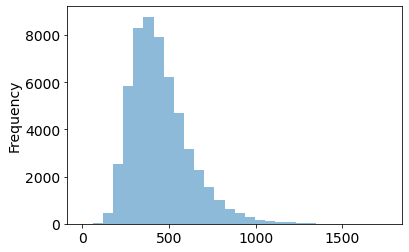

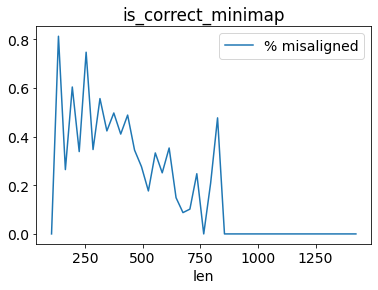

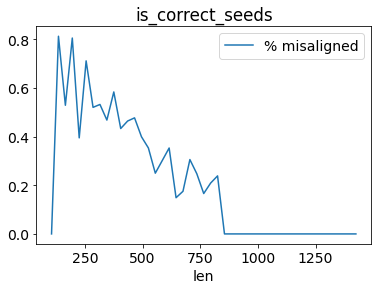

In [9]:
d='results/ecoli_head1000000_linear_long_ccs/'
check_minimap(d+'minimap2/aln.sam', d+'astar-seeds/alignments.tsv', d+'gt/sd_0001.maf')

#check_minimap(minimap_sam_fn='results/ecoli_head1000000_linear_long_ccs/minimap.sam', seeds_tsv_fn='results/ecoli_head1000000_linear_long_ccs/astarix-seeds.tsv', gt_maf_fn='results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam
results/ecoli_head1000000_linear_long_300_ccs/astar-seeds/alignments.tsv
results/ecoli_head1000000_linear_long_300_ccs/gt/sd_0001.maf
(78750, 18) (78571, 12)
Difference: {'S1_68423', 'S1_68381', 'S1_68495', 'S1_68437', 'S1_68360', 'S1_68402', 'S1_68491', 'S1_68490', 'S1_68401', 'S1_68414', 'S1_68330', 'S1_68438', 'S1_68442', 'S1_68377', 'S1_68395', 'S1_68446', 'S1_68364', 'S1_68494', 'S1_68365', 'S1_68496', 'S1_68345', 'S1_68408', 'S1_68359', 'S1_68369', 'S1_68426', 'S1_68368', 'S1_68374', 'S1_68398', 'S1_68480', 'S1_68409', 'S1_68447', 'S1_68350', 'S1_68404', 'S1_68431', 'S1_68332', 'S1_68489', 'S1_68382', 'S1_68420', 'S1_68340', 'S1_68464', 'S1_68362', 'S1_68486', 'S1_68391', 'S1_68384', 'S1_68449', 'S1_68462', 'S1_68411', 'S1_68380', 'S1_68470', 'S1_68469', 'S1_68416', 'S1_68463', 'S1_68413', 'S1_68393', 'S1_68344', 'S1_68430', 'S1_68387', 'S1_68348', 'S1_68435', 'S1_68425', 'S1_68366', 'S1_68485', 'S1_68399', 'S1_68419'

,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_1,0,322617,60,17M1I65M1I13M1D102M1D14M1D85M,*,0,0,ACCCGCTACATTTTACAGGGTTGCCCAACGCAAAAATGCCCGGAAG...,5/>P;L6T050/8/=?XF/K6+779A&Y(>)4G@.2;9-?E6H0;6...,NM:i:5,322617,298,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,298,ACCCGCTACATTTTACAGGGTTGCCCAACGCAAAAATGCCCGGAAG...,ACCCGCTACATTTTACAGGgTTGCCCAACGCAAAAATGCCCGGAAG...,5,322618,0.453020,0.083893,0.0,0.003181,0.000268,1,0.536913,134.999960,322616,+
S1_10001,0,98708,60,99M1D76M1D20M2D14M1D12M,*,0,0,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,Vd1;M`M~~nG`S@C=K_4EA0~XuJJ~mEN<5CFS*PR'HWMYTN...,NM:i:5,98708,221,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,221,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,5,98713,2.606335,0.416290,0.0,0.008219,0.000793,1,3.022625,576.000035,98707,+
S1_10003,0,298253,60,36M1I123M1D35M,*,0,0,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGGCGCAGCCC...,\d{eph~QzPSdoPVK8Bb5HHm1:502MWR<9=[&$WBWpjK_Ga...,NM:i:2,298253,195,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,195,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGGCGCAGCCC...,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGgCGCAGCCC...,2,298253,0.600000,0.097436,0.0,0.002667,0.000179,1,0.697436,117.000000,298252,+
S1_10005,0,815073,60,78M1D4M1D105M1D2M1D6M1D47M,*,0,0,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,"L,DM4~>~j~~~kLG~=Z[^e~~EV~Rp~~I~~6~nn~_~y[|KWr...",NM:i:5,815073,242,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,242,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,5,815078,11.458678,1.165289,0.0,0.032989,0.003383,1,12.623967,2773.000076,815072,+
S1_10007,0,535532,60,52M1D133M1D24M1D40M1D35M1D9M,*,0,0,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,U;~^P0~OkU?~~7~Drr~q~~7\~~~-~~X~sKF~L~~gJ~R~~~...,NM:i:5,535532,293,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,293,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,5,535537,0.423208,0.081911,0.0,0.003416,0.000210,1,0.505119,123.999944,535531,+


,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand,is_correct_minimap,is_correct_seeds
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_10043,0,391715,0,171M1D63M,*,0,0,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,@~k~P~~B~/~I[~~xt~l~H{\\~z~~(P~~~iu6Ep~~\~~fsd...,NM:i:1,391715,234,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,234,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,1,-10000,0.435897,0.068376,0.0,0.002672,0.000202,1,0.504273,101.999898,391714,+,True,False
S1_10739,0,608287,0,16M1D69M1D14M1D5M1D7M1D3M1I22M1D11M1I38M,*,0,0,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,"@@DI`IApNG@?BD3\@N?L,DAJ<FTCVYK9I79F7M\<K<M4X8...",NM:i:8,608287,187,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,187,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,8,15671,3.716578,1.000000,0.0,0.009125,0.000696,1,4.716578,695.000086,608286,+,True,False
S1_10811,0,274053,0,117M1D20M1D57M1D9M1D91M,*,0,0,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,M:xFptA:\<'-;~NMDd6gNV}ufiMFHIQSQLV80T~aM%PGY~...,NM:i:6,274053,294,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,294,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,6,687953,2.374150,0.639456,0.0,0.011102,0.001161,1,3.013606,698.000100,274052,+,True,False
S1_10925,0,567704,0,31M1D169M1D79M,*,0,0,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,~as~UlDMny:lJ2[yhOk^~*'e~`_ay~V^NyPf~BbikS~|UH...,NM:i:2,567704,279,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,279,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,2,-10000,0.476703,0.064516,0.0,0.002995,0.000246,1,0.541219,133.000137,567703,+,True,False
S1_10945,16,392262,0,12M1D41M1D87M2D91M1D52M1D11M,*,0,0,GACACAGGCAGGCGTGTGCGCGGTAGCTGACCGGGCTGAACTTCCG...,E@A2mc.D2Pi+_AnSsB~Nja~?8R_9LRjPHb+R~gaF1SL<GU...,NM:i:6,392262,294,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,294,CAAAGCAATGTCCGCGTGCTCCGGGTGGCCCGCAGCGGCTGGTATA...,CAAAGCAATGTCCGCGTGCTCCGGGTGGCCCGCAGCGGCTGGTATA...,6,567188,0.806122,0.190476,0.0,0.005331,0.000387,1,0.996598,236.999868,315630,+,False,False


Checked 39286 alignments:
minimap_loc overlaps with gt_loc in: 39052
differs in: 234 (0.596%)
Checked 39286 alignments:
start overlaps with gt_loc in: 39026
differs in: 260 (0.662%)
     len  % misaligned
7  105.0      0.000000
5  135.0      0.680272
4  165.0      0.858369
2  195.0      0.885173
1  225.0      0.504982
3  255.0      0.548546
0  285.0      0.523158
6  315.0      0.404040
     len  % misaligned
7  105.0      4.545455
5  135.0      0.680272
4  165.0      1.103617
2  195.0      0.860585
1  225.0      0.682408
3  255.0      0.621686
0  285.0      0.578962
6  315.0      0.202020


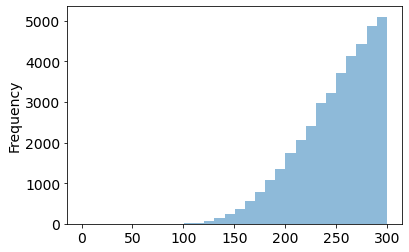

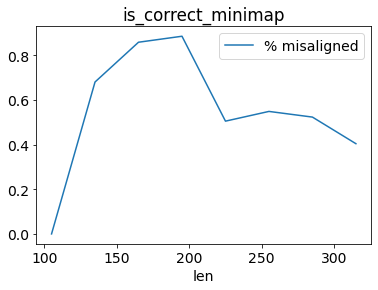

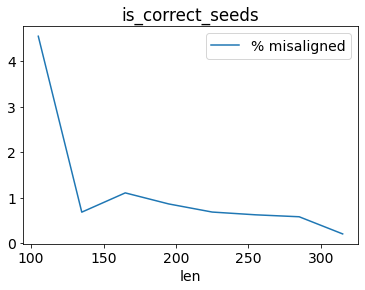

In [10]:
d='results/ecoli_head1000000_linear_long_300_ccs/'
check_minimap(d+'minimap2/aln.sam', d+'astar-seeds/alignments.tsv', d+'gt/sd_0001.maf')
#check_minimap('results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam', 'results/ecoli_head1000000_linear_long_300_ccs/long_300_ccs/sd_0001.maf')

In [11]:
#check_minimap(minimap_sam_fn='results/ecoli_head1000000_linear_long_clr/minimap.sam', seeds_tsv_fn='results/ecoli_head1000000_linear_long_clr/astarix-seeds.tsv', gt_maf_fn='results/ecoli_head1000000_linear_long_clr/gt/sd_0001.maf')

In [12]:
#d='results/ecoli_head1000000_linear_long_500_clr/'
#check_minimap(d+'minimap2/aln.sam', d+'astar-seeds/alignments.tsv', d+'gt/sd_0001.maf')

In [13]:
## NOT USED
def compare_costs(df, col1='cost_seeds', col2='cost_minimap'):
    eq, seeds_better, minimap_better = 0, 0, 0
    
    for index, row in df.iterrows():
        #display(row)
        #print(index, row[col1], row[col2])
        if row[col1] == row[col2]:
            eq += 1
        elif row[col1] < row[col2]:
            seeds_better += 1
        elif row[col1] > row[col2]:
            #assert(False)
            #print('!!!')
            minimap_better += 1
        else:
            print("Mistake")
            assert(False)
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' better in:', seeds_better)
    print(col2 + ' minimap better in:', minimap_better)
    print('            Equal in:', eq)

In [15]:
#compare_eq(df, 'minimap_loc', 'gt_loc')
#compare_costs(df, 'cost', 'minimap_str_cost')

In [18]:
#def draw_plot(df, colx, coly):
#    ax = df.plot(colx, coly)


In [19]:
#draw_plot(df, 'query_len', 'is_correct')

In [23]:
def get_fa(fa_fn):
    f = open(fa_fn, 'r')
    f.readline()
    s = f.readline().strip()
    f.close()
    display('fa:', s[:100])
    return s

def get_fq(fq_fn):
    d = defaultdict(str)
    f = open(fq_fn, 'r')
    while True:
        read = f.readline()[1:].strip()
        if not read:
            break
        s = f.readline().strip()
        f.readline() # +read
        f.readline() # phreds
        d[read] = s
    f.close()
    display("fq:", dict(list(d.items())[0:3]))
    return d

def get_minimap_alignments(minimap_sam_fn):
    df = pd.read_csv(minimap_sam_fn, skiprows=2, header=None, delim_whitespace=True, index_col=0, usecols=[0,1,2,3,4,5,6,7,8,9,10])
    d = defaultdict(set)
    for read, row in df.iterrows():
        loc = int(row[2]) if row[2] != '*' else -100000
        d[read].add(loc)
    display("minimap2:", dict(list(d.items())[0:20]))
    return d

def get_astarix_alignments(astarix_tsv_fn):
    df = pd.read_csv(astarix_tsv_fn, delim_whitespace=True)
    display(df.head(20))
    d = defaultdict(set)
    for key, row in df.iterrows():
        read = row[4]
        loc = int(row[10])
        d[read].add(loc)
    display("astarix:", dict(list(d.items())[0:20]))
    return d
    
def get_pbsim_alignments(pbsim_maf_fn):
    df = read_maf(pbsim_maf_fn)
    #display(df.head())
    d = defaultdict(set)
    for read, row in df.iterrows():
        loc = int(row[0])
        d[read].add(loc)
    display("pbsim:", dict(list(d.items())[0:20]))
    return d
    
d = 'results/ecoli_ccs/'

fa = get_fa(d+'ecoli.fasta')
fq = get_fq(d+'head20000.fastq')
gt = get_pbsim_alignments(d+'sd_0001.maf')
mm = get_minimap_alignments(d+'minimap2.sam')
seeds = get_astarix_alignments(d+'astar-seeds.tsv')

#check_minimap(d+'minimap2.sam', d+'astar-seeds.tsv', d+'sd_0001.maf')

'fa:'

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT'

'fq:'

{'S1_1': 'GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGGCAGGCGATACCACGCGTGGGCCATTATCAATGACGTTGGGTATCCACGGCTTTGTTCCGATGGACGAGCTTAACGCGCTCTGGGGCGAAACCGGGTGACTGGATCTATGTGACCGGTACACCGGGCGAAGCGCCGCCGGGCTGGCGATTTGCAAAACCGTTTGCAGGTTGCCGATGCTAAAGATGCGGACTACTTGATCAAACGTCATCTCCGTTCATCC',
 'S1_2': 'AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAATTGTCGCACTGGCGGTGGGTATCCCGGTGATGGTCTGGGGGTGATCGGCGATAACATGATGGTCACCGCTGACACACCGCAGCCTGTGGTTGGTTATCGGCCTGATAACCCTGCAGTGATGGTTTTCGCCGGCGGCCATTTTTACCGCAGGCATGGAAAAGCCTGCTGAACGGTGCGGCGACGATGGATACGCTGGTGGCGCTGGGTACTGGCGTGGCGTGGCTCTATTCGATGAGCGTCAACCTGTGGCCGCAGTGGTTCCCGATGGAGCGCGACATCTTATTACGAAGCCAGCGCGATGATTATCGGTCTGATCAATCTCGGCCATATGCTGGAAGCGCGCGCACGGCAGCGTTCTCTAAGGCGCTGGAAAAGTTACTCGATTTAACCCCGCCGACGGCACGCCTGG',
 'S1_3': 'TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTCGCCATTACACCTTTGGCCCGCAAATCGTTGGTTTGTTGGGATTGGGGGTTGGCAAAAACGCGGCACTAGGGAATGTGGTGATTAGCTGTTCTTTTGCTCGGCTGTATTCCGCCGATGCTGTGGTTAAACACTGCCGGACGGCGTCCATTGTTGATTGGCAGCTTTGCCATGATGACGCTGGCGCTGGCGGTTTTGGGG

'pbsim:'

{'S1_1': {435945},
 'S1_2': {510397},
 'S1_3': {46539},
 'S1_4': {421793},
 'S1_5': {521004},
 'S1_6': {963220},
 'S1_7': {662958},
 'S1_8': {120702},
 'S1_9': {118465},
 'S1_10': {628234},
 'S1_11': {315756},
 'S1_12': {767865},
 'S1_13': {761744},
 'S1_14': {674887},
 'S1_15': {271308},
 'S1_16': {135470},
 'S1_17': {742290},
 'S1_18': {20258},
 'S1_19': {442385},
 'S1_20': {407089}}

'minimap2:'

{'S1_1': {435946},
 'S1_2': {510398},
 'S1_3': {46540},
 'S1_4': {421794},
 'S1_5': {521005},
 'S1_6': {963221},
 'S1_7': {662959},
 'S1_8': {120703},
 'S1_9': {118466},
 'S1_10': {628235},
 'S1_11': {315757, 391921, 567308},
 'S1_12': {767866},
 'S1_13': {761745},
 'S1_14': {674888},
 'S1_15': {271309},
 'S1_16': {135471},
 'S1_17': {742291},
 'S1_18': {20259, 258371, 279634, 291105},
 'S1_19': {442386},
 'S1_20': {407090}}

,ref,refsize,algo,operation,readname,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best
0,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_1,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435951,+,15.251880,3.266917,0.0,0.043242,0.004498,0
1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_1,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435953,+,15.251880,3.266917,0.0,0.043242,0.004498,0
2,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_1,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435952,+,15.251880,3.266917,0.0,0.043242,0.004498,0
3,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_2,0.0,454,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,8,510400,-,0.427313,0.105727,0.0,0.003193,0.000371,1
4,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_3,0.0,493,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,10,46550,+,1.462475,0.340771,0.0,0.009153,0.001627,1
5,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_4,0.0,521,CGTTTAAACATCCAGCCAATCAACAGCACAACAATCCACGGAAACC...,CGTTTAAACATCCAGCCAATCAACAGCACAACAATCCACGGAAACC...,12,421796,-,3.291747,0.800384,0.0,0.022931,0.004558,1
6,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_5,0.0,546,ATAAATTCGGCGGCAACGAGAACCAGCTCGACGGCTATGAGAAATG...,ATAAATTCGGCGGCAACGAGAACCAGCTCGACGGCTATGAGAAATG...,8,521007,+,1.045788,0.223443,0.0,0.008653,0.002441,1
7,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_6,0.0,608,GACTTGGTCATGATTCCTCCGGTTCCTTAAGGCAAATTAAGCGGCT...,GACTTGGTCATGATTCCTCCGGTTCCTTAAGGCAAATTAAGCGGCT...,10,963223,-,1.934211,0.498355,0.0,0.016268,0.004256,1
8,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_7,0.0,694,TTTCATGCGACCACGCGGAATGGTCAGGTACACGTCTTTATCAACC...,TTTCATGCGACCACGCGGAATGGTCAGGTACACGTCTTTATCAACC...,15,662969,+,2.925072,0.727666,0.0,0.028192,0.007588,1
9,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,S1_8,0.0,440,TTGTGGTATTAACGCCATCAACCTGACAACGTTAAAGTGTTTGGCG...,TTGTGGTATTAACGCCATCAACCTGACAACGTTAAAGTGTTTGGCG...,6,120705,-,0.436364,0.081818,0.0,0.003278,0.000448,1


'astarix:'

{'S1_1': {435951, 435952, 435953},
 'S1_2': {510400},
 'S1_3': {46550},
 'S1_4': {421796},
 'S1_5': {521007},
 'S1_6': {963223},
 'S1_7': {662969},
 'S1_8': {120705},
 'S1_9': {118472},
 'S1_10': {628237},
 'S1_11': {315765, 391923, 567316},
 'S1_12': {767868},
 'S1_13': {761752},
 'S1_14': {674890},
 'S1_15': {271316},
 'S1_16': {135473},
 'S1_17': {742295},
 'S1_18': {20261},
 'S1_19': {442394},
 'S1_20': {407092}}

In [24]:
def editdist(p, t):
    #print(p,t)
    p = '!' + p
    t = '!' + t
    inf = 10000000000
    
    d = dict()
    for j in range(0,len(t)):
        d[(0,j)] = 0
    for i in range(1,len(p)):
        for j in range(1,len(t)):
            m = inf
            if (i-1,j-1) in d:
                m = min(m, d[i-1,j-1] + (p[i] != t[j]))
            if (i-1,j) in d:
                m = min(m, d[i-1,j]+1)    
            if (i,j-1) in d:
                m = min(m, d[i,j-1]+1)
            d[(i,j)] = m
    ans = inf
    for j in range(0,len(t)):
        if (len(p)-1, j) in d:
            ans = min(ans, d[(len(p)-1, j)])
    return ans

def rc_char(c):
     if c == 'A':
        return 'T'
     if c == 'T':
        return 'A'
     if c == 'C':
        return 'G'
     if c == 'G':
        return 'C'
     assert(false)

def rc(s):
    ans = ''
    for c in s[::-1]:
        ans += rc_char(c)
    return ans

def editdist_rc(p, t):
    return editdist(p,t+'!'+rc(t))

print(editdist('ACCAG', 'ACCTG'))
print(editdist_rc('ACCAG', 'AACCG'))
print(editdist_rc('CTGGT', 'AACCG'))

1
1
1


In [27]:
def add_editdist(fq, fa, d):
    ans = dict()
    for read, locs in d.items():
        s = dict()
        for loc in locs:
            t = fa[loc-1500:loc+1500]
            s[loc] = editdist_rc(fq[read], t)
            #print(loc, s[loc])
        ans[read] = s
    return ans

n = 200

gt_ed = add_editdist(fq, fa, dict(list(gt.items())[0:n]))
display("gt_ed:", gt_ed)

mm_ed = add_editdist(fq, fa, dict(list(mm.items())[0:n]))
display("mm_ed:", mm_ed)

seeds_ed = add_editdist(fq, fa, dict(list(seeds.items())[0:n]))
display("seeds_ed:", seeds_ed)

'gt_ed:'

{'S1_1': {435945: 10},
 'S1_2': {510397: 8},
 'S1_3': {46539: 10},
 'S1_4': {421793: 11},
 'S1_5': {521004: 8},
 'S1_6': {963220: 10},
 'S1_7': {662958: 15},
 'S1_8': {120702: 6},
 'S1_9': {118465: 10},
 'S1_10': {628234: 5},
 'S1_11': {315756: 9},
 'S1_12': {767865: 4},
 'S1_13': {761744: 8},
 'S1_14': {674887: 13},
 'S1_15': {271308: 10},
 'S1_16': {135470: 8},
 'S1_17': {742290: 4},
 'S1_18': {20258: 8},
 'S1_19': {442385: 8},
 'S1_20': {407089: 6},
 'S1_21': {146238: 8},
 'S1_22': {143726: 12},
 'S1_23': {199290: 10},
 'S1_24': {750648: 8},
 'S1_25': {737663: 17},
 'S1_26': {532068: 12},
 'S1_27': {578334: 10},
 'S1_28': {482831: 23},
 'S1_29': {127021: 10},
 'S1_30': {958500: 8},
 'S1_31': {723355: 20},
 'S1_32': {736337: 7},
 'S1_33': {674854: 8},
 'S1_34': {616295: 9},
 'S1_35': {968559: 10},
 'S1_36': {337753: 21},
 'S1_37': {753855: 13},
 'S1_38': {316587: 10},
 'S1_39': {638265: 8},
 'S1_40': {565555: 8},
 'S1_41': {780204: 20},
 'S1_42': {693760: 4},
 'S1_43': {421380: 12},


'mm_ed:'

{'S1_1': {435946: 10},
 'S1_2': {510398: 8},
 'S1_3': {46540: 10},
 'S1_4': {421794: 11},
 'S1_5': {521005: 8},
 'S1_6': {963221: 10},
 'S1_7': {662959: 15},
 'S1_8': {120703: 6},
 'S1_9': {118466: 10},
 'S1_10': {628235: 5},
 'S1_11': {391921: 9, 567308: 9, 315757: 9},
 'S1_12': {767866: 4},
 'S1_13': {761745: 8},
 'S1_14': {674888: 13},
 'S1_15': {271309: 10},
 'S1_16': {135471: 8},
 'S1_17': {742291: 4},
 'S1_18': {291105: 28, 258371: 21, 20259: 8, 279634: 28},
 'S1_19': {442386: 8},
 'S1_20': {407090: 6},
 'S1_21': {146239: 8},
 'S1_22': {143727: 12},
 'S1_23': {199291: 10},
 'S1_24': {750649: 8},
 'S1_25': {737664: 17},
 'S1_26': {532069: 12},
 'S1_27': {578335: 10},
 'S1_28': {482832: 23},
 'S1_29': {127022: 10},
 'S1_30': {958501: 8},
 'S1_31': {723356: 20},
 'S1_32': {736338: 7},
 'S1_33': {674858: 8},
 'S1_34': {616296: 9},
 'S1_35': {968560: 10},
 'S1_36': {337754: 21},
 'S1_37': {753856: 13},
 'S1_38': {316588: 10},
 'S1_39': {638266: 8},
 'S1_40': {565556: 8},
 'S1_41': {78

'seeds_ed:'

{'S1_1': {435952: 10, 435953: 10, 435951: 10},
 'S1_2': {510400: 8},
 'S1_3': {46550: 10},
 'S1_4': {421796: 11},
 'S1_5': {521007: 8},
 'S1_6': {963223: 10},
 'S1_7': {662969: 15},
 'S1_8': {120705: 6},
 'S1_9': {118472: 10},
 'S1_10': {628237: 5},
 'S1_11': {391923: 9, 567316: 9, 315765: 9},
 'S1_12': {767868: 4},
 'S1_13': {761752: 8},
 'S1_14': {674890: 13},
 'S1_15': {271316: 10},
 'S1_16': {135473: 8},
 'S1_17': {742295: 4},
 'S1_18': {20261: 8},
 'S1_19': {442394: 8},
 'S1_20': {407092: 6},
 'S1_21': {146247: 8},
 'S1_22': {143729: 12},
 'S1_23': {199294: 10},
 'S1_24': {750651: 8},
 'S1_25': {737679: 17},
 'S1_26': {532071: 12},
 'S1_27': {578338: 10},
 'S1_28': {482834: 23},
 'S1_29': {127032: 10},
 'S1_30': {958503: 8},
 'S1_31': {723359: 20},
 'S1_32': {736340: 7},
 'S1_33': {674865: 8},
 'S1_34': {616298: 9},
 'S1_35': {968569: 10},
 'S1_36': {337756: 21},
 'S1_37': {753866: 13},
 'S1_38': {316590: 10},
 'S1_39': {638276: 8},
 'S1_40': {565558: 8},
 'S1_41': {780213: 20},
 

In [ ]:
fd
fd
sf
ds

In [37]:
def smashed_dict(d):
    L = {}
    for loc, dist in d.items():
        if len(L) == 0 or min([abs(int(loc)-int(x)) for x in L]) > 100:
            L[loc] = dist
    return L

def cmp_ed(gt, d):
    cnt = dict()
    cnt['not_aligned_reads'] = 0
    cnt['total_alignments'] = 0
    cnt['FP'] = 0
    for read, s_gt in gt.items():
        assert(len(s_gt) == 1)
        gt_loc = list(s_gt)[0]
        gt_dist = s_gt[gt_loc]
        
        if read not in d:
            cnt['not_aligned_reads'] += 1
        else:
            s_d = smashed_dict(d[read])
            for loc, dist in s_d.items():
                cnt['total_alignments'] += 1
                if dist > gt_dist:
                    cnt['FP'] += 1
                    print('wrong alignment: ', read, loc, dist)
    return cnt

display('minimap2: ', cmp_ed(gt_ed, mm_ed))
display('seeds: ', cmp_ed(gt_ed, seeds_ed))

wrong alignment:  S1_18 291105 28
wrong alignment:  S1_18 258371 21
wrong alignment:  S1_18 279634 28


'minimap2: '

{'not_aligned_reads': 0, 'total_alignments': 206, 'FP': 3}

'seeds: '

{'not_aligned_reads': 0, 'total_alignments': 203, 'FP': 0}

In [73]:
from tqdm.notebook import tqdm

def smashed_set(d):
    L = set()
    for loc in d:
        if len(L) == 0 or min([abs(int(loc)-int(x)) for x in L]) > 100:
            L.add(loc)
    return L

def cmp_set(gt, d):
    cnt = dict()
    cnt['expected_reads'] = 0
    cnt['not_aligned_reads'] = 0
    cnt['aligned_reads'] = 0
    cnt['alignments'] = 0
    cnt['missed_correct'] = 0
    cnt['FP'] = 0
    for read, s_gt in tqdm(gt.items()):
        assert(len(s_gt) == 1)
        gt_loc = list(s_gt)[0]
        cnt['expected_reads'] += 1
        dist_gt = -1
        #if cnt['expected_reads'] % 100 == 0:
        #    print('{:2}% '.format(100.0 * cnt['expected_reads'] / len(gt)))
        
        if read not in d:
            cnt['not_aligned_reads'] += 1
        else:
            cnt['aligned_reads'] += 1
            s_d = smashed_set(d[read])
            found = False
            
            for loc in s_d:
                if abs(gt_loc-loc) < 1500:
                    found = True
                    cnt['correct_alignments'] += 1
                else:
                    if dist_gt == -1:
                        t_gt = fa[gt_loc-1500:gt_loc+1500]
                        dist_gt = editdist_rc(fq[read], t_gt)
        
                    t_d = fa[loc-1500:loc+1500]
                    dist_d = editdist_rc(fq[read], t_d)
                    if dist_d > dist_gt:
                        cnt['FP'] += 1
                    else:
                        cnt['correct_alignments'] += 1
                cnt['alignments'] += 1
            if not found:
                cnt['missed_correct'] += 1
                
    return cnt

n = 20000
gt_short = dict(list(gt.items())[0:n])

#display(mm)
seeds_summary = cmp_set(gt_short, seeds)
display('seeds: ', seeds_summary)

mm_summary = cmp_set(gt_short, mm)
display('minimap2: ', mm_summary)

  0%|          | 0/20000 [00:00<?, ?it/s]

'seeds: '

{'expected_reads': 20000,
 'not_aligned_reads': 0,
 'aligned_reads': 20000,
 'alignments': 20218,
 'missed_correct': 0,
 'FP': 0}

  0%|          | 0/20000 [00:00<?, ?it/s]

'minimap2: '

{'expected_reads': 20000,
 'not_aligned_reads': 21,
 'aligned_reads': 19979,
 'alignments': 20313,
 'missed_correct': 1,
 'FP': 118}

In [76]:
def to_perc(d):
    ans = {}
    ans['reads'] = d['expected_reads']
    ans['not_aligned_reads'] = 100.0 * d['not_aligned_reads'] / d['expected_reads']
    ans['missed_correct'] = 100.0 * d['missed_correct'] / d['expected_reads']
    #ans['alignments'] = d['alignments']
    ans['correct_alignments'] = d['alignments'] - d['FP']
    ans['misalignments'] = 100.0 * d['FP'] / d['alignments']
    return ans

display('seeds:',to_perc(seeds_summary))
display('minimap2:',to_perc(mm_summary))

'seeds:'

{'reads': 20000,
 'not_aligned_reads': 0.0,
 'missed_correct': 0.0,
 'correct_alignments': 20218,
 'misalignments': 0.0}

'minimap2:'

{'reads': 20000,
 'not_aligned_reads': 0.105,
 'missed_correct': 0.005,
 'correct_alignments': 20195,
 'misalignments': 0.5809087776300891}

In [77]:
pd.DataFrame.from_dict({'seeds': seeds_summary, 'minimap2': mm_summary})

,seeds,minimap2
expected_reads,20000,20000
not_aligned_reads,0,21
aligned_reads,20000,19979
alignments,20218,20313
missed_correct,0,1
FP,0,118
